# Composite Micromechanics

This Jupyter Notebook is meant to show how the Weibull Analysis of Composite Fibres works.

## Load Packages

In [15]:
#Load packages that will be used in the notebook
import numpy as np
import matplotlib.pyplot as plt
import numpy.polynomial.polynomial as poly
import pandas as pd
import math

## Functions

In [25]:
def prob_f_weib(pf_cumm): #Probability function from the cummulative probabilty
    Pf = [pf_cumm[0]]
    points = pf_cumm.size
    for pos in range(1,points):
        Pf.append(pf_cumm[pos] - pf_cumm[pos-1])
    
    return Pf, sum(Pf)

def prob_f_cumm(stress,sigma_star,m): #Cummulative probabilty
    return 1 - np.exp(-1*np.power((stress/sigma_star),m))

def err_sigma(m,i,err_m,err_i):
    return np.exp(-i/m)*np.sqrt((-err_i/m)**2 + ((i*err_m)/(m)**2)**2)

def arithmetic_mean(sigma_star, m):
    return sigma_star*(math.gamma(1+(1/m)))

def round_val(value, decimals = 1):
    return np.round_(value, decimals)

## Weibull Tests

Probability Function Integral: 1.0000


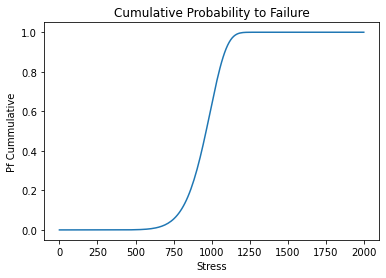

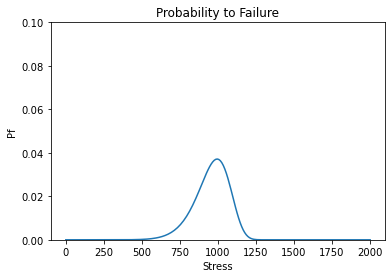

In [5]:
#Plot some data to see the Weibull distribution
#----
sigmaStar = 1000
m = 10
stressStart = 0
stressEnd = 2000
points = 200
#----

stressRange = np.linspace(stressStart,stressEnd,points)

#Failure probability at stress, cummulative
Pf_cumm = prob_f_cumm(stressRange,sigmaStar,m)

#Failure at stress
Pf,sum_prob = prob_f_weib(Pf_cumm)
    
#Plot the data
plt.plot(stressRange,Pf_cumm)
plt.title("Cumulative Probability to Failure")
plt.xlabel('Stress')
plt.ylabel('Pf Cummulative')

plt.figure(0)
plt.plot(stressRange,Pf)
plt.title("Probability to Failure")
plt.ylim(0, 0.1)
plt.xlabel('Stress')
plt.ylabel('Pf')

print(f'Probability Function Integral: {sum_prob:.4f}') #This should be 1

## Weibull Analysis

### Data for Analysis

#### Create Data

Create fake data to use in the Weibull Analysis.

In [4]:
rng = np.random.default_rng()
#----
m = 5. 
sigmaStar = 2000
dataPoints = 200
noiseSize = 100
#----

weibDist = sigmaStar*rng.weibull(m, dataPoints)

#Add noise to the data so it looks more like real data
noise = (np.random.rand(dataPoints)-0.5)*noiseSize

#----
stressData = weibDist + noise
#----

#### Read Data

Read the data from a text file

In [6]:
pdData = pd.read_csv('FailureData.txt')
stressData = pdData.to_numpy()[:,0]

dataPoints = stressData.size

Data information

In [7]:
print(f'Min Stress: {np.min(stressData):.2f}')
print(f'Max Stress: {np.max(stressData):.2f}')

Min Stress: 1180.00
Max Stress: 4531.00


### Weibull Analysis

In [41]:
#Order the stress measured from lower to higher
stressOrdered = np.sort(stressData)

#Rank array
r = np.linspace(1,dataPoints,dataPoints)

# Transform the data to the needed plot
#x axis data -> ln(stress)
#y axis data -> ln(ln(1/(1-P)))
#Find P first, P = (r-0.5)/N
P = (r-0.5)/dataPoints
    
xAxisData = np.log(stressOrdered)
yAxisData = np.log(np.log(1/(1-P)))


#Fit a line to the transformed data
p,V = np.polyfit(xAxisData,yAxisData,deg=1,cov=True)
_,stats = poly.polyfit(xAxisData,yAxisData,1,full=True)
residual = stats[0][0]
R2 = 1 - residual / (dataPoints * yAxisData.var())

print("Linear Fit:")
print(f' |->  m: {p[0]:.4f} +/- {np.sqrt(V[0][0]):.4f}')
print(f' |->  c: {p[1]:.4f} +/- {np.sqrt(V[1][1]):.4f}')
print(f' |->  R2: {R2:.3f}')

#Calculate Weibull constants
m = round_val(p[0])
c = round_val(p[1])
sigmaStar = round_val(np.exp((-c)/m),0)

#Calculate the error for the constants
err_m = round_val(np.sqrt(V[0][0])) #The error for Weibull cosntant m is the error of the slope
err_c = round_val(np.sqrt(V[1][1])) 
err_sigma_star = round_val(err_sigma(m,c,err_m,err_c),0)

#Calcualte arithmetic mean
arithmeticMeanSigma = round_val(arithmetic_mean(sigmaStar, m),0)

print("\nWeibull Constants:")
print(f' |->  m: {m} +/- {err_m}')
print(f' |->  sigma*: {sigmaStar} +/- {err_sigma_star}')

print("\nExtras:")
print(f' |->  sigma (arithmetic mean): {arithmeticMeanSigma}')

Linear Fit:
 |->  m: 5.0158 +/- 0.1573
 |->  c: -40.2647 +/- 1.2451
 |->  R2: 0.964

Weibull Constants:
 |->  m: 5.0 +/- 0.2
 |->  sigma*: 3165.0 +/- 1272.0

Extras:
 |->  sigma (arithmetic mean): 2906.0


### Plots

Text(0, 0.5, 'Pf')

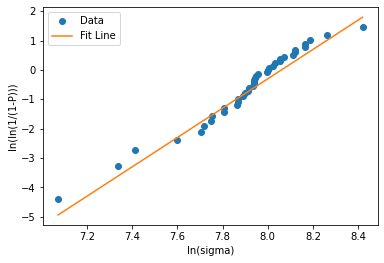

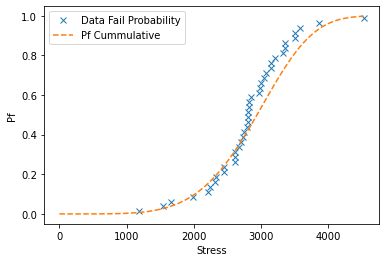

In [42]:
#Plot both data and fit
plt.plot(xAxisData,yAxisData,'o',label='Data')
plt.plot(xAxisData,m*xAxisData + c,label='Fit Line')
#plt.plot(xAxisData,(m+err_m)*xAxisData + c-err_c,'r--')
#plt.plot(xAxisData,(m-err_m)*xAxisData + c+err_c,'r--')
plt.legend()
plt.xlabel('ln(sigma)')
plt.ylabel('ln(ln(1/(1-P)))')

plt.figure(0)
stressRangePlot = np.linspace(0,np.max(stressData),dataPoints*2)
Pf_cumm = prob_f_cumm(stressRangePlot,sigmaStar,m)

plt.plot(stressOrdered,P,'x',label='Data Fail Probability')
plt.plot(stressRangePlot,Pf_cumm,'--',label='Pf Cummulative')
plt.legend()
plt.xlabel('Stress')
plt.ylabel('Pf')